In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load & pre-proccess data

In [4]:
df = pd.read_csv("/kaggle/input/mrbeast-youtube-comment-sentiment-analysis/sentiment_analysis_dataset.csv", sep=',', quotechar='"', engine='python', on_bad_lines='skip')
df.head()

,Comment,Sentiment
0,Achieving million views in days is dangerous,Positive
1,How many people here want to participate in su...,Neutral
2,Mrbeast is slowly turning into mrjigsaw,Negative
3,genuinely can't believe how dystopian this is,Negative
4,Have of the worlds smartest people compete in ...,Neutral


In [5]:
df = df.dropna(subset=['Comment'])
print("\nAfter dropping missing comments:")
print(df.isnull().sum())


After dropping missing comments:
Comment      0
Sentiment    0
dtype: int64


In [6]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [8]:
df['ProcessedComments'] = df['Comment'].apply(preprocess_text)
df.head()

,Comment,Sentiment,ProcessedComments
0,Achieving million views in days is dangerous,Positive,achiev million view day danger
1,How many people here want to participate in su...,Neutral,mani peopl want particip challeng
2,Mrbeast is slowly turning into mrjigsaw,Negative,mrbeast slowli turn mrjigsaw
3,genuinely can't believe how dystopian this is,Negative,genuin cant believ dystopian
4,Have of the worlds smartest people compete in ...,Neutral,world smartest peopl compet seri intellectu pu...


In [9]:
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])  # 0,1,2
num_classes = len(le.classes_)

In [10]:
from collections import Counter
token_counter = Counter()
for comment in df['ProcessedComments']:
    token_counter.update(comment.split())

vocab = {word: idx+1 for idx, (word, _) in enumerate(token_counter.most_common())}  # 0 reserved for padding
vocab_size = len(vocab) + 1

def encode_text(text):
    return torch.tensor([vocab.get(word, 0) for word in text.split()], dtype=torch.long)

In [11]:
X = [encode_text(text) for text in df['ProcessedComments']]
X_padded = pad_sequence(X, batch_first=True)  
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

## Dataset & DataLoader

In [13]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_tensor, y_train_tensor)
test_dataset  = TextDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)

## Model

In [14]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, rnn_type='LSTM', num_layers=1):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if rnn_type=='LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        if isinstance(h_n, tuple):  # LSTM returns (h_n, c_n)
            h_n = h_n[0]
        out = self.fc(h_n[-1])  # use last layer's hidden state
        return out

In [15]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, device='cpu', patience=5):
    model.to(device)
    train_losses, test_losses = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # --- Evaluation ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # --- Early stopping check ---
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # --- Load best model ---
    model.load_state_dict(best_model_wts)

    # --- Plot losses ---
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model

Epoch [1/50] - Train Loss: 0.6975, Test Loss: 0.6695


Epoch [2/50] - Train Loss: 0.6705, Test Loss: 0.6687


Epoch [3/50] - Train Loss: 0.6722, Test Loss: 0.6681


Epoch [4/50] - Train Loss: 0.6697, Test Loss: 0.6681


Epoch [5/50] - Train Loss: 0.6694, Test Loss: 0.6680


Epoch [6/50] - Train Loss: 0.6695, Test Loss: 0.6682


Epoch [7/50] - Train Loss: 0.6687, Test Loss: 0.6682


Epoch [8/50] - Train Loss: 0.6699, Test Loss: 0.6690


Epoch [9/50] - Train Loss: 0.6431, Test Loss: 0.5407


Epoch [10/50] - Train Loss: 0.4300, Test Loss: 0.3777


Epoch [11/50] - Train Loss: 0.3191, Test Loss: 0.3194


Epoch [12/50] - Train Loss: 0.2506, Test Loss: 0.3051


Epoch [13/50] - Train Loss: 0.1896, Test Loss: 0.2949


Epoch [14/50] - Train Loss: 0.1619, Test Loss: 0.2476


Epoch [15/50] - Train Loss: 0.1462, Test Loss: 0.2471


Epoch [16/50] - Train Loss: 0.1680, Test Loss: 0.2205


Epoch [17/50] - Train Loss: 0.1148, Test Loss: 0.2065


Epoch [18/50] - Train Loss: 0.0966, Test Loss: 0.1918


Epoch [19/50] - Train Loss: 0.0811, Test Loss: 0.1828


Epoch [20/50] - Train Loss: 0.0793, Test Loss: 0.1528


Epoch [21/50] - Train Loss: 0.0645, Test Loss: 0.1442


Epoch [22/50] - Train Loss: 0.0508, Test Loss: 0.1364


Epoch [23/50] - Train Loss: 0.0426, Test Loss: 0.1144


Epoch [24/50] - Train Loss: 0.0249, Test Loss: 0.1368


Epoch [25/50] - Train Loss: 0.0198, Test Loss: 0.1072


Epoch [26/50] - Train Loss: 0.0296, Test Loss: 0.1080


Epoch [27/50] - Train Loss: 0.0160, Test Loss: 0.1045


Epoch [28/50] - Train Loss: 0.0075, Test Loss: 0.1213


Epoch [29/50] - Train Loss: 0.0075, Test Loss: 0.1282


Epoch [30/50] - Train Loss: 0.0092, Test Loss: 0.1329


Epoch [31/50] - Train Loss: 0.0089, Test Loss: 0.1360


Epoch [32/50] - Train Loss: 0.0068, Test Loss: 0.1294
Early stopping triggered at epoch 32


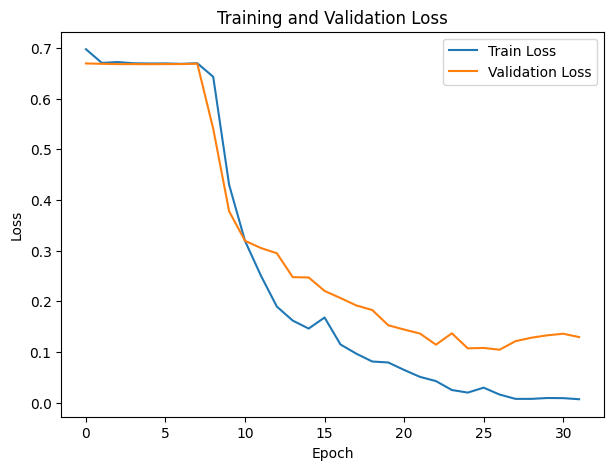

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 50
hidden_dim = 64

model = SentimentRNN(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, output_dim=num_classes, rnn_type='LSTM')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, device=device)

In [17]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.9791425260718424
Confusion Matrix:
 [[ 10   0   0]
 [  0 251   6]
 [  2  10 584]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      1.00      0.91        10
     Neutral       0.96      0.98      0.97       257
    Positive       0.99      0.98      0.98       596

    accuracy                           0.98       863
   macro avg       0.93      0.99      0.95       863
weighted avg       0.98      0.98      0.98       863



Epoch [1/50] - Train Loss: 0.6949, Test Loss: 0.6688


Epoch [2/50] - Train Loss: 0.6481, Test Loss: 0.5758


Epoch [3/50] - Train Loss: 0.3887, Test Loss: 0.3107


Epoch [4/50] - Train Loss: 0.2100, Test Loss: 0.2213


Epoch [5/50] - Train Loss: 0.1365, Test Loss: 0.1823


Epoch [6/50] - Train Loss: 0.0986, Test Loss: 0.1393


Epoch [7/50] - Train Loss: 0.0764, Test Loss: 0.1481


Epoch [8/50] - Train Loss: 0.0709, Test Loss: 0.1343


Epoch [9/50] - Train Loss: 0.0573, Test Loss: 0.1293


Epoch [10/50] - Train Loss: 0.0498, Test Loss: 0.1219


Epoch [11/50] - Train Loss: 0.0495, Test Loss: 0.1134


Epoch [12/50] - Train Loss: 0.0413, Test Loss: 0.1353


Epoch [13/50] - Train Loss: 0.0351, Test Loss: 0.1064


Epoch [14/50] - Train Loss: 0.0270, Test Loss: 0.0971


Epoch [15/50] - Train Loss: 0.0263, Test Loss: 0.0973


Epoch [16/50] - Train Loss: 0.0257, Test Loss: 0.0936


Epoch [17/50] - Train Loss: 0.0214, Test Loss: 0.0868


Epoch [18/50] - Train Loss: 0.0151, Test Loss: 0.0849


Epoch [19/50] - Train Loss: 0.0137, Test Loss: 0.0856


Epoch [20/50] - Train Loss: 0.0135, Test Loss: 0.0991


Epoch [21/50] - Train Loss: 0.0174, Test Loss: 0.0876


Epoch [22/50] - Train Loss: 0.0147, Test Loss: 0.0775


Epoch [23/50] - Train Loss: 0.0100, Test Loss: 0.0928


Epoch [24/50] - Train Loss: 0.0058, Test Loss: 0.0819


Epoch [25/50] - Train Loss: 0.0038, Test Loss: 0.0872


Epoch [26/50] - Train Loss: 0.0051, Test Loss: 0.0666


Epoch [27/50] - Train Loss: 0.0039, Test Loss: 0.1014


Epoch [28/50] - Train Loss: 0.0149, Test Loss: 0.0800


Epoch [29/50] - Train Loss: 0.0076, Test Loss: 0.1000


Epoch [30/50] - Train Loss: 0.0065, Test Loss: 0.0879


Epoch [31/50] - Train Loss: 0.0027, Test Loss: 0.0865
Early stopping triggered at epoch 31


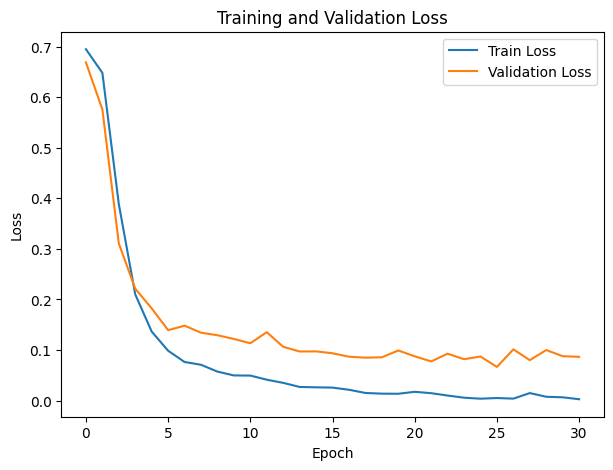

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 50
hidden_dim = 64

model = SentimentRNN(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, output_dim=num_classes, rnn_type='GRU')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, device=device)

In [19]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.9872537659327926
Confusion Matrix:
 [[ 10   0   0]
 [  0 253   4]
 [  2   5 589]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      1.00      0.91        10
     Neutral       0.98      0.98      0.98       257
    Positive       0.99      0.99      0.99       596

    accuracy                           0.99       863
   macro avg       0.94      0.99      0.96       863
weighted avg       0.99      0.99      0.99       863



Epoch [1/50] - Train Loss: 0.6840, Test Loss: 0.6721


Epoch [2/50] - Train Loss: 0.6746, Test Loss: 0.6718


Epoch [3/50] - Train Loss: 0.6716, Test Loss: 0.6699


Epoch [4/50] - Train Loss: 0.6724, Test Loss: 0.6709


Epoch [5/50] - Train Loss: 0.6699, Test Loss: 0.6705


Epoch [6/50] - Train Loss: 0.6693, Test Loss: 0.6712


Epoch [7/50] - Train Loss: 0.6644, Test Loss: 0.6559


Epoch [8/50] - Train Loss: 0.6395, Test Loss: 0.6562


Epoch [9/50] - Train Loss: 0.6457, Test Loss: 0.6625


Epoch [10/50] - Train Loss: 0.6521, Test Loss: 0.6536


Epoch [11/50] - Train Loss: 0.6555, Test Loss: 0.6524


Epoch [12/50] - Train Loss: 0.6546, Test Loss: 0.6592


Epoch [13/50] - Train Loss: 0.6526, Test Loss: 0.6687


Epoch [14/50] - Train Loss: 0.6528, Test Loss: 0.6624


Epoch [15/50] - Train Loss: 0.6549, Test Loss: 0.6685


Epoch [16/50] - Train Loss: 0.6529, Test Loss: 0.6635
Early stopping triggered at epoch 16


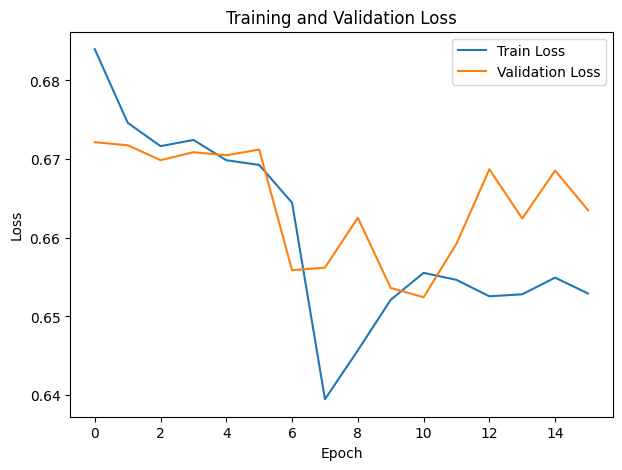

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 50
hidden_dim = 64

model = SentimentRNN(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, output_dim=num_classes, rnn_type='RNN')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, device=device)

In [21]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.6906141367323291
Confusion Matrix:
 [[  0   0  10]
 [  0   0 257]
 [  0   0 596]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        10
     Neutral       0.00      0.00      0.00       257
    Positive       0.69      1.00      0.82       596

    accuracy                           0.69       863
   macro avg       0.23      0.33      0.27       863
weighted avg       0.48      0.69      0.56       863



## Pre-trained embeddings

In [22]:
glove_path = "/kaggle/input/glove6b50d/glove.6B.50d.txt"

embedding_dim = 50
embeddings_index = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


In [23]:
vocab_size = len(vocab) + 1  # +1 for padding idx 0
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocab.items():
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec
    else:
        # random init if word not in GloVe
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [24]:
class SentimentRNN_Pretrained(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, rnn_type='LSTM', num_layers=1, embedding_matrix=None):
        super(SentimentRNN_Pretrained, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Load pre-trained embeddings
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = True  # True to fine-tune embeddings, False to freeze

        if rnn_type=='LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        if isinstance(h_n, tuple):  # LSTM returns (h_n, c_n)
            h_n = h_n[0]
        out = self.fc(h_n[-1])  # last layer hidden state
        return out


Epoch [1/50] - Train Loss: 0.7275, Test Loss: 0.6643


Epoch [2/50] - Train Loss: 0.6574, Test Loss: 0.5723


Epoch [3/50] - Train Loss: 0.4463, Test Loss: 0.3593


Epoch [4/50] - Train Loss: 0.2747, Test Loss: 0.3533


Epoch [5/50] - Train Loss: 0.2168, Test Loss: 0.2647


Epoch [6/50] - Train Loss: 0.1699, Test Loss: 0.2209


Epoch [7/50] - Train Loss: 0.1435, Test Loss: 0.1997


Epoch [8/50] - Train Loss: 0.1213, Test Loss: 0.1761


Epoch [9/50] - Train Loss: 0.1450, Test Loss: 0.1879


Epoch [10/50] - Train Loss: 0.1011, Test Loss: 0.1983


Epoch [11/50] - Train Loss: 0.0811, Test Loss: 0.1508


Epoch [12/50] - Train Loss: 0.0997, Test Loss: 0.1616


Epoch [13/50] - Train Loss: 0.0778, Test Loss: 0.1505


Epoch [14/50] - Train Loss: 0.0649, Test Loss: 0.1488


Epoch [15/50] - Train Loss: 0.0784, Test Loss: 0.1667


Epoch [16/50] - Train Loss: 0.0749, Test Loss: 0.1424


Epoch [17/50] - Train Loss: 0.0602, Test Loss: 0.1426


Epoch [18/50] - Train Loss: 0.0788, Test Loss: 0.1524


Epoch [19/50] - Train Loss: 0.0830, Test Loss: 0.1654
Early stopping triggered at epoch 19


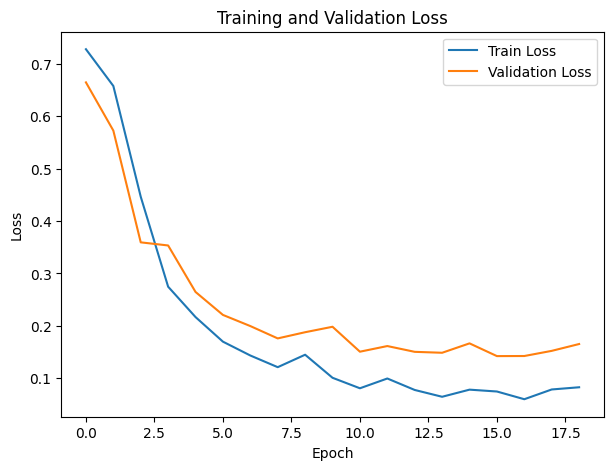

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 64

model = SentimentRNN_Pretrained(
    vocab_size=vocab_size,
    embed_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=num_classes,
    rnn_type='LSTM',
    embedding_matrix=embedding_matrix
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(
    model, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=50,
    device=device,
    patience=3
)


In [26]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.9629200463499421
Confusion Matrix:
 [[  0  10   0]
 [  0 253   4]
 [  0  18 578]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        10
     Neutral       0.90      0.98      0.94       257
    Positive       0.99      0.97      0.98       596

    accuracy                           0.96       863
   macro avg       0.63      0.65      0.64       863
weighted avg       0.95      0.96      0.96       863



Epoch [1/50] - Train Loss: 0.7354, Test Loss: 0.6614


Epoch [2/50] - Train Loss: 0.5602, Test Loss: 0.4863


Epoch [3/50] - Train Loss: 0.3080, Test Loss: 0.3156


Epoch [4/50] - Train Loss: 0.1886, Test Loss: 0.2539


Epoch [5/50] - Train Loss: 0.1334, Test Loss: 0.1942


Epoch [6/50] - Train Loss: 0.0999, Test Loss: 0.1681


Epoch [7/50] - Train Loss: 0.0829, Test Loss: 0.1703


Epoch [8/50] - Train Loss: 0.0754, Test Loss: 0.1716


Epoch [9/50] - Train Loss: 0.0661, Test Loss: 0.1727
Early stopping triggered at epoch 9


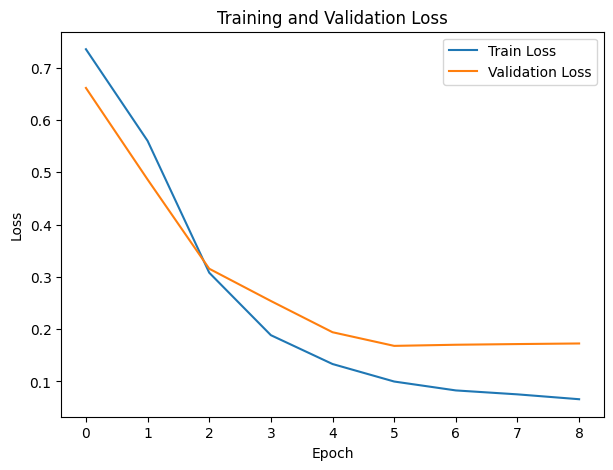

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 64

model = SentimentRNN_Pretrained(
    vocab_size=vocab_size,
    embed_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=num_classes,
    rnn_type='GRU',
    embedding_matrix=embedding_matrix
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(
    model, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=50,
    device=device,
    patience=3
)


In [28]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.9571263035921205
Confusion Matrix:
 [[  3   7   0]
 [  2 248   7]
 [  0  21 575]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.60      0.30      0.40        10
     Neutral       0.90      0.96      0.93       257
    Positive       0.99      0.96      0.98       596

    accuracy                           0.96       863
   macro avg       0.83      0.74      0.77       863
weighted avg       0.96      0.96      0.96       863



Epoch [1/50] - Train Loss: 0.7171, Test Loss: 0.6679


Epoch [2/50] - Train Loss: 0.6704, Test Loss: 0.6734


Epoch [3/50] - Train Loss: 0.6708, Test Loss: 0.6687


Epoch [4/50] - Train Loss: 0.6708, Test Loss: 0.6727
Early stopping triggered at epoch 4


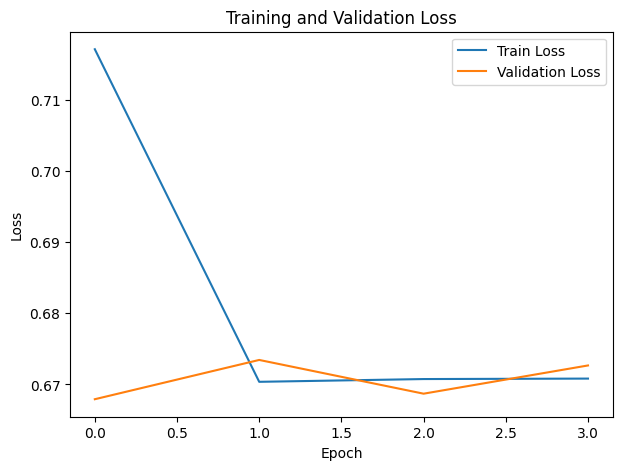

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 64

model = SentimentRNN_Pretrained(
    vocab_size=vocab_size,
    embed_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=num_classes,
    rnn_type='RNN',
    embedding_matrix=embedding_matrix
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(
    model, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=50,
    device=device,
    patience=3
)


In [30]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.6906141367323291
Confusion Matrix:
 [[  0   0  10]
 [  0   0 257]
 [  0   0 596]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        10
     Neutral       0.00      0.00      0.00       257
    Positive       0.69      1.00      0.82       596

    accuracy                           0.69       863
   macro avg       0.23      0.33      0.27       863
weighted avg       0.48      0.69      0.56       863



## Conclusion

**GRU** turned out to be the best model in terms of accuracy. Pre-trained embedding increased accuracy by **0.01** approximately. NNs outperformed classic ML models.